# MoCapRasp arena calibration and testing 
This notebook is a **visual debug tool** to **calibrate and test extrinsics parameters** of the eROBOTICA visual tracking arena. 

**IMPORTANT NOTES**

- The CSV files containing captured data from the clients must be collected via the `CEC.py` (Camera Extrinsics Calibration), `GPE.py` (Ground Plane Estimation) and `SCR.py` (Standard Capture Routine) codes, respectively (with the `--save` flag).

- These files are saved in the `dataSaves` folder, which contains a folder for the capture date, and each CSV is named after the time it was done.   

- Please just change the variables in the noted cells only.

- All the non-essential and debug only image plots have been commented, but not removed. Feel free to explore them.

- The calibration of intrinsics has already been done with [this repository](https://github.com/debOliveira/myCameraCalibrator) and stored in the file `../mcr/constants.py`. Please alter the matrices accordingly. 

- All the mathematical basis of this code can be found on the thesis text.

## Configuration 
Just importing libraries and self made functions used in the previous offline arena doodle.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time,math
import numpy as np
from cv2 import circle,triangulatePoints,cvtColor,COLOR_GRAY2RGB,computeCorrespondEpilines,putText,FONT_HERSHEY_SIMPLEX,imwrite
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline

from mcr.misc.constants import *
from mcr.misc.math import *
from mcr.misc.cameras import *
from mcr.misc.markers import *
from mcr.misc.plot import *

## Calibration of extrinsincs

The following cell sets up the name of the CSV where the data is stored and the size of the arrays to be read. Alter to the options used with the `CEC.py` command.

In [2]:
##########################################
### YOU MAY CHANGE THE VARIABLES BELOW ###
##########################################

dfCSV = np.genfromtxt('dataSaves/27-09-23/CEC-17-54-02.csv', delimiter=',')
verbose = False # verbose flag for reading the data and interpolation 
nCameras = 4    # number of cameras
recTime = 120    # recording time, in seconds
step = 1/100    # step of the interpolated DF

### Reading coordinates and ordering markers
Now, we read each line of the CSV that has the following strings:
- *`Ax|Ay|Bx|By|Cx|Cy`*: the x and y undistorted coordinates of each collinear marker A, B or C. 
- *`time`*: the PTS in seconds from when the image was captured.
- *`image number`*: the number of the image in the processing loop at the Raspberry station.
- *`index`*: the number the Raspberry station (varies from 0 to `nCameras`).

Then we check if there was no processing error in the data (e.g. if there is occlusion between markers or PTS divergion). Finally, we check how many images have been missed comparing to the image number of the last valid image from the stream. Note that we may receive delayed packages between Raspberries, but they come always in order from each stream station.

*The markers are ordered using the certainty algorithm proposed in this dissertation.* The timestamp period in which we locate the valid images of each camera's stream is recorded in a separate array and later used for interpolation.

In [3]:
# initiating empty arrays
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)
missed,invalid,swap = np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32)
lastImgNumber = np.zeros(nCameras,dtype=np.int32)
certainty,intervals,timeIntervals = np.zeros(nCameras,dtype=np.bool8),[],[]
dfOrig,tol = [],0.25
for k in range(nCameras):
    dfOrig.append([])
    intervals.append([])
    timeIntervals.append([])

# reading the CSV per line
while i!=dfCSV.shape[0]:
    line = dfCSV[i]
    # get data from the line
    idx = int(line[8])
    undCoord,timeNow,imgNumber = line[0:6].reshape(-1,2),line[6],line[7]
    i+=1
    # if the timestamp has diverged, discard the image (processing error)
    if counter[idx]:
        if abs(timeNow-lastTime[idx])>1e9: 
            if verbose: print('time missmatch')
            missed[idx]+=1
            invalid[idx]+=1
            continue
    # check if no image was missed
    if imgNumber>lastImgNumber[idx]+1: invalid[idx] = imgNumber-lastImgNumber[idx]
    # check collinearity, occlusion and order markers per proximity
    if isCollinear(*undCoord) and not occlusion(undCoord,5) and not np.any(undCoord<0):     
        if invalid[idx]>=10 or not counter[idx]: 
            if certainty[idx]:
                beg,end = intervals[idx][-1],counter[idx]-1
                timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])
                if verbose: print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end][6]/1e6,2))+'s')
            prev,certainty[idx] = [],False
            intervals[idx].append(counter[idx])
        else:
            if not (counter[idx]-1): prev = np.array(dfOrig[idx][0:6]).reshape(-1,2)
            else: prev = np.array(dfOrig[idx][-1,0:6]).reshape(-1,2)
        undCoord, _ = orderCenterCoord(undCoord,prev)
        undCoord = np.array(undCoord)
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx]+=1
        invalid[idx]+=1
        continue
    # update datasets variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = timeNow,imgNumber,0
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(6),timeNow))
    else: dfOrig[idx] = np.vstack((dfOrig[idx],np.hstack((undCoord.reshape(6),timeNow))))
    counter[idx]+=1
    # check if ABC is in order smaller to largest, change if not (but only if certain of the distribution = if at least two images indicate that yes)
    if not certainty[idx]:
        for [A,B,C] in undCoord.reshape([-1, 3, 2]):
            if np.linalg.norm(A-B)/np.linalg.norm(C-B)>(2-tol) and np.linalg.norm(A-B)>20:
                swap[idx] += 1
                if swap[idx]>2:    
                    swap[idx],certainty[idx] = 0,True
                    dfOrig[idx][intervals[idx][-1]:counter[idx],0:2],dfOrig[idx][intervals[idx][-1]:counter[idx],4:6] = np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],4:6]),np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],0:2])
            if np.linalg.norm(C-B)/np.linalg.norm(A-B)>(2-tol) and np.linalg.norm(C-B)>20:  certainty[idx] = True

# get last interval validity
for idx in range(nCameras):
    if not len(dfOrig[idx]): continue
    if certainty[idx]:
        beg,end = intervals[idx][-1],counter[idx]-1
        timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])    
        if verbose: print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end,6]/1e6,2))+'s')

# outcome
for i in range(nCameras): 
    print('  >> camera '+str(i)+': '+str(len(dfOrig[i]))+' valid images, missed '+str(int(missed[i]))+' images')
            
## debug received centroids  
'''for idx in range(nCameras):
    os.system('rm pics/cam'+str(idx)+'/*')
    for j in range(0,dfOrig[idx].shape[0]):
        pts,name,img,k = dfOrig[idx][j,0:6].reshape(-1,2),int(dfOrig[idx][j,6]),np.ones((540,960,3))*255,0
        for k in range(0,3):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)''';


  >> camera 0: 2602 valid images, missed 80 images
  >> camera 1: 2845 valid images, missed 112 images
  >> camera 2: 2442 valid images, missed 103 images
  >> camera 3: 2133 valid images, missed 72 images


### Computing the extrinsics parameters

Having the centroids ordered, we can interpolate all cameras to a common database and triangulate the markers within the valid time intervals. Then we estimate the fundamental and essential matrices, which can be decomposed to rotation and translation between cameras.

It is known that the best calibration result is obtained from cameras that have 90 degrees difference between them. Therefore, we only calibrated sequential pairs (i.g. (0,1), (1,2), (2,3), ...). A bundle adjustment should be added for a larger number of cameras.

interpolated 4125 images between cams 0 and 1
[INFO] Computing fundamental and essential matrix between cameras 0-1
	Scale between real world and triang. point cloud is:  420.79
	L_AC >> mean = 15.747cm, std. dev = 0.1624cm, rms = 0.169cm
	L_AB >> mean = 5.2244cm, std. dev = 0.0766cm, rms = 0.1471cm
	L_BC >> mean = 10.5266cm, std. dev = 0.1225cm, rms = 0.2576cm
	Images distant more than 1% from the real value = 1401/4125
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  422.28
	L_AC >> mean = 15.7423cm, std. dev = 0.0937cm, rms = 0.1029cm
	L_AB >> mean = 5.2312cm, std. dev = 0.0539cm, rms = 0.1304cm
	L_BC >> mean = 10.5129cm, std. dev = 0.1026cm, rms = 0.2363cm


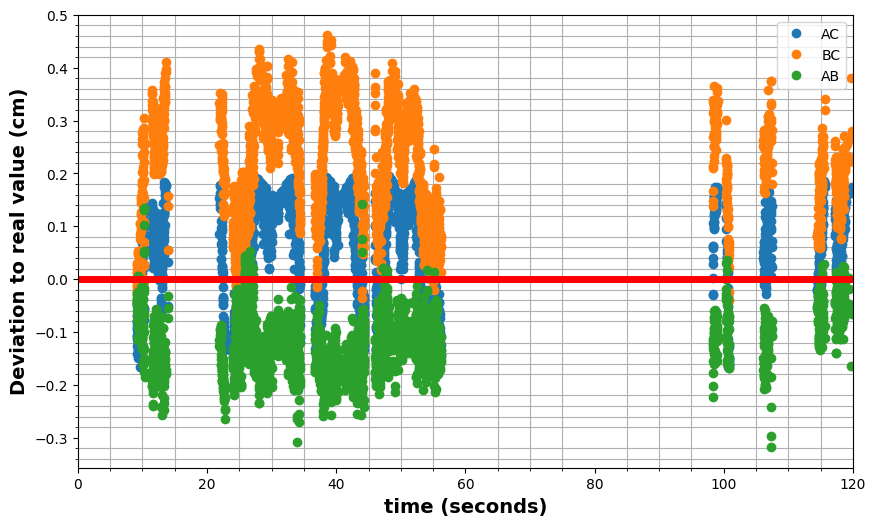

--
interpolated 2563 images between cams 1 and 2
[INFO] Computing fundamental and essential matrix between cameras 1-2
	Scale between real world and triang. point cloud is:  470.06
	L_AC >> mean = 15.7435cm, std. dev = 0.0897cm, rms = 0.0997cm
	L_AB >> mean = 5.2299cm, std. dev = 0.068cm, rms = 0.1381cm
	L_BC >> mean = 10.5152cm, std. dev = 0.0739cm, rms = 0.2275cm
	Images distant more than 1% from the real value = 316/2563
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  470.7
	L_AC >> mean = 15.7445cm, std. dev = 0.0764cm, rms = 0.0884cm
	L_AB >> mean = 5.228cm, std. dev = 0.0646cm, rms = 0.1381cm
	L_BC >> mean = 10.5182cm, std. dev = 0.0733cm, rms = 0.2301cm


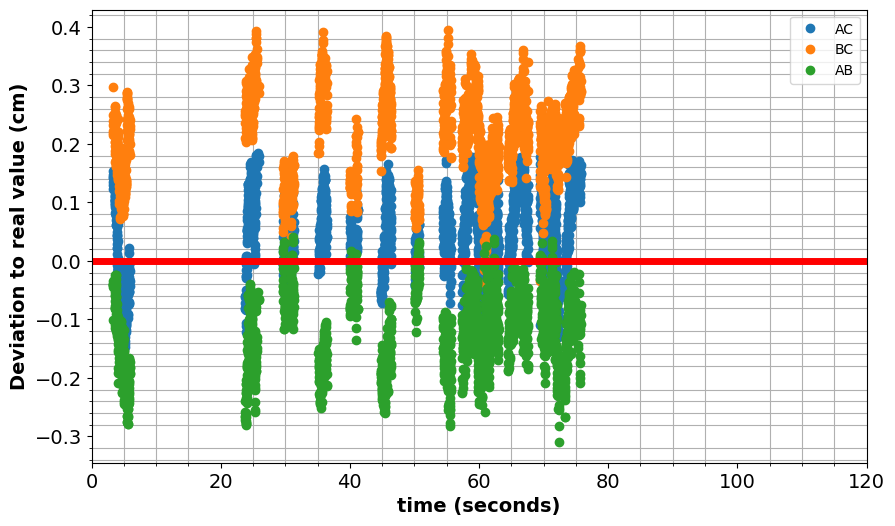

--
interpolated 2122 images between cams 2 and 3
[INFO] Computing fundamental and essential matrix between cameras 2-3
	Scale between real world and triang. point cloud is:  412.4
	L_AC >> mean = 15.7513cm, std. dev = 0.2101cm, rms = 0.2162cm
	L_AB >> mean = 5.2229cm, std. dev = 0.1083cm, rms = 0.167cm
	L_BC >> mean = 10.5298cm, std. dev = 0.1258cm, rms = 0.2619cm
	Images distant more than 1% from the real value = 782/2122
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  412.74
	L_AC >> mean = 15.7486cm, std. dev = 0.1344cm, rms = 0.1429cm
	L_AB >> mean = 5.2235cm, std. dev = 0.0806cm, rms = 0.15cm
	L_BC >> mean = 10.5264cm, std. dev = 0.0826cm, rms = 0.241cm


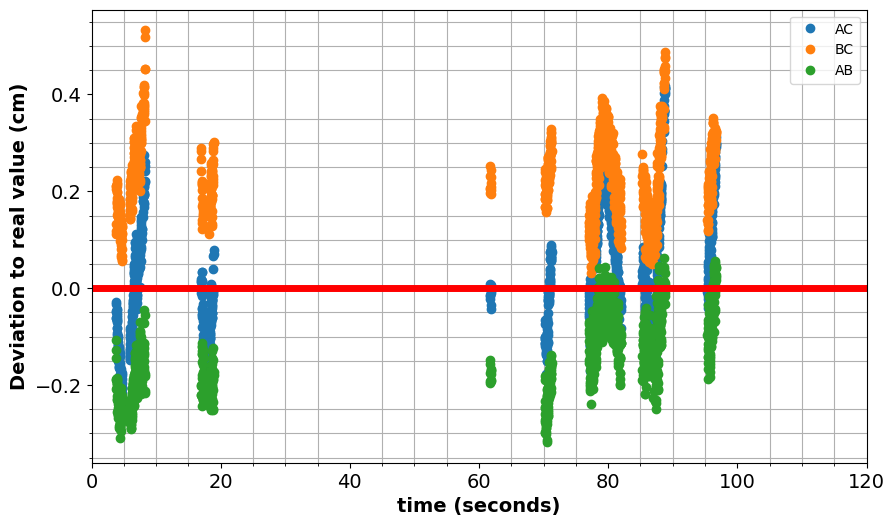

--


In [4]:
# initiating empty arrays
rotation,translation,scale,FMatrix,points3D_perPair,ts_perPair,firCentroids,secCentroids = [np.identity(3)],[np.zeros((1,3))],[[1]],[],[],[],[],[]
allIdx = [(i,i+1) for i in range(nCameras-1)]           # list of sequential pairs (0,1),(1,2),(2,3)...
#allIdx = list(combinations(list(range(nCameras)),2))   # list of all possible pairs

# setting up plotting function for epipolar lines
from cv2 import line
def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,0,255),(0,255,0),(255,0,0)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = line(img1, (x0,y0), (x1,y1), color,1)
        img1 = circle(img1,tuple(pt1),5,color,-1)
        img2 = circle(img2,tuple(pt2),5,color,-1)
        i+=1
    return img1,img2

# calibration loop for a pair of sequential cameras
for [m,n] in allIdx:
    # compute valid time intersection for interpolation
    intersections = [[max(first[0], second[0]), min(first[1], second[1])]  
                        for first in timeIntervals[m] for second in timeIntervals[n]  
                        if max(first[0], second[0]) <= min(first[1], second[1])]
    # create and fill inteprolation dataset based on the intersection of valid time intervals 
    dfInterp = np.zeros((int(recTime/step),2*6+1))
    dfInterp[:,-1] = np.arange(0,recTime,step)
    for [beg,end] in intersections:
        for idx in [m,n]:
            validIdx = [i for i in range(0,dfOrig[idx].shape[0]) if beg<=dfOrig[idx][i,-1]<=end]
            coord,timeNow = dfOrig[idx][validIdx,0:6],dfOrig[idx][validIdx,6]/1e6
            if timeNow.shape[0]<=2: continue
            lowBound,highBound = math.ceil(timeNow[0]/step),math.floor(timeNow[-1]/step)
            if verbose: print('interpolated #'+str(idx+1)+' from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
            tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
            if timeNow.shape[0]<=2: continue
            ff = CubicSpline(timeNow,coord,axis=0)
            if idx == m: dfInterp[tNew,0:6] = ff(tNew*step)
            else: dfInterp[tNew,6:12] = ff(tNew*step)
    # get data from the interpolation dataset
    dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) for idx in range(2) if not np.any(dfInterp[i][idx*6:idx*6+6])]),axis=0)
    if dfInterp.shape[0] < 10: 
        print('[ERROR] no valid image intersection for cameras '+str(m)+' and '+str(n))
        break
    centroids1,centroids2 = dfInterp[:,0:6].reshape(-1,2),dfInterp[:,6:12].reshape(-1,2)
    print('interpolated '+str(dfInterp.shape[0])+' images between cams '+str(m)+' and '+str(n))
    # estimate fundamental and essential matrices 
    print('[INFO] Computing fundamental and essential matrix between cameras '+str(m)+'-'+str(n))
    F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2),verbose=verbose)
    E = np.matmul(cameraMat[n].T, np.matmul(F, cameraMat[m]))
    if verbose: print("\nEssenc. Mat.\n", E.round(4))
    # decompose to rotation and translation between cameras
    R, t = decomposeEssentialMat(E, cameraMat[m], cameraMat[n], np.array(centroids1), np.array(centroids2))
    if np.any(np.isnan(R)): print('no valid rotation matrix')
    else:
        if verbose:
            print("\nRot. Mat.\n", R.round(4))
            print("\nTrans. Mat.\n", t.round(4))
    # create projection matrices and triangulate to compute scale
    P1,P2 = np.hstack((cameraMat[m], [[0.], [0.], [0.]])),np.matmul(cameraMat[n], np.hstack((R, t.T)))
    projPt1,projPt2 = projectionPoints(np.array(centroids1)),projectionPoints(np.array(centroids2))
    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
    points3d = (points4d[:3, :]/points4d[3, :]).T
    if points3d[0, 2] < 0: points3d = -points3d
    tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx,time_idx = 0,15.7,5.35,10.3,[],[],[],0,[],[]
    # compute sdt deviation and plot beautiful stuff
    for [A, B, C] in points3d.reshape([-1, 3, 3]):
        L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
        tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
        k = k + 3
        L_AC_vec.append(L_rec_AC)
        L_BC_vec.append(L_rec_BC)
        L_AB_vec.append(L_rec_AB)   
    lamb = tot/k
    print('\tScale between real world and triang. point cloud is: ', lamb.round(2))
    print('\tL_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
    print('\tL_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
    print('\tL_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
    # debug plot for error before refiment
    '''fig = plt.figure(figsize=(10, 6), dpi=200)
    L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
    plt.plot(dfInterp[:,-1],L_AC_vec_plot, 'o', label="AC")
    plt.plot(dfInterp[:,-1],L_BC_vec_plot, 'o', label="BC")
    plt.plot(dfInterp[:,-1],L_AB_vec_plot, 'o', label="AB")
    plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
    plt.grid()
    plt.xlabel("time (seconds)",fontsize=14, fontweight='bold')
    plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
    plt.legend()
    ax = fig.axes
    ax[0].minorticks_on()
    plt.grid(which='both')
    plt.xlim(0,recTime)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.draw()
    plt.show()'''
    # getting indexes of images where the AC markers are further than 1% of the real distance
    points3d_new,i,k= points3d*lamb,0,0
    for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
        L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
        valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
        if not valid: 
            i = i + 1
            false_idx.extend((k,k+1,k+2))
            time_idx.append(int(k/3))
        k+=3
    print("\tImages distant more than 1% from the real value = " + str(i)+'/'+str(int(points3d.shape[0]/3)))
    # deleting points and refining estimation of the fundamental and essential matrices
    print("[INFO] Refining fundamental matrix estimation")
    centroids1,centroids2,dfInterp=np.delete(centroids1,false_idx,axis=0),np.delete(centroids2,false_idx,axis=0),np.delete(dfInterp,time_idx,axis=0)
    F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2),verbose = 0)
    E = np.matmul(cameraMat[n].T, np.matmul(F, cameraMat[m]))
    if verbose: print("\nEssenc. Mat.\n", E.round(4))
    # decompose to rotation and translation between cameras
    R, t = decomposeEssentialMat(E, cameraMat[m], cameraMat[n], np.array(centroids1), np.array(centroids2))
    if np.any(np.isnan(R)): print('no valid rotation matrix')
    else:
        if verbose:
            print("\nRot. Mat.\n", R.round(4))
            print("\nTrans. Mat.\n", t.round(4))
    P1,P2 = np.hstack((cameraMat[m], [[0.], [0.], [0.]])),np.matmul(cameraMat[n], np.hstack((R, t.T)))
    projPt1,projPt2 = projectionPoints(np.array(centroids1)),projectionPoints(np.array(centroids2))
    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
    points3d = (points4d[:3, :]/points4d[3, :]).T
    if points3d[0, 2] < 0: points3d = -points3d
    tot,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx = 0,[],[],[],0,[]
    # compute sdt deviation and plot beautiful stuff
    for [A, B, C] in points3d.reshape([-1, 3, 3]):
        L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
        tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
        k = k + 3
        L_AC_vec.append(L_rec_AC)
        L_BC_vec.append(L_rec_BC)
        L_AB_vec.append(L_rec_AB)   
    lamb = tot/k
    print('\tScale between real world and triang. point cloud is: ', lamb.round(2))
    print('\tL_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
    print('\tL_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
    print('\tL_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
    # debug plot for error after refiment
    fig = plt.figure(figsize=(10, 6), dpi=100)
    L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
    plt.plot(dfInterp[:,-1],L_AC_vec_plot, 'o', label="AC")
    plt.plot(dfInterp[:,-1],L_BC_vec_plot, 'o', label="BC")
    plt.plot(dfInterp[:,-1],L_AB_vec_plot, 'o', label="AB")
    plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
    plt.grid()
    plt.xlabel("time (seconds)",fontsize=14, fontweight='bold')
    plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
    plt.legend()
    ax = fig.axes
    ax[0].minorticks_on()
    plt.grid(which='both')
    plt.xlim(0,recTime)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.draw()
    plt.show()
    # saving extrinsics parameters to later use
    translation.append(t)
    rotation.append(R)
    scale.append([lamb])
    FMatrix.append(F)
    points3D_perPair.append(points3d)
    ts_perPair.append(dfInterp[:,-1])
    firCentroids.append(centroids1)
    secCentroids.append(centroids2)
    # epipolar lines plot  
    '''img1,img2,n = np.ones((720,960))*255,np.ones((720,960))*255,0
    pts1,pts2 = np.int32(centroids1[n:n+3].reshape(-1,2)),np.int32(centroids2[n:n+3].reshape(-1,2))
    lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
    lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.figure(figsize=(20, 16),dpi=100)
    plt.subplot(121),plt.imshow(img5.astype(np.uint8))
    plt.subplot(122),plt.imshow(img3.astype(np.uint8))
    plt.show()'''
    print('--')


### Update reference to the 0th camera

With the rotation and translation in scale between cameras, we have to compound the rigid body transformations and obtain the pose of each camera in relation to the 0th camera. The triangulated 3D points must also be rotated and translated in reference to the world origin.

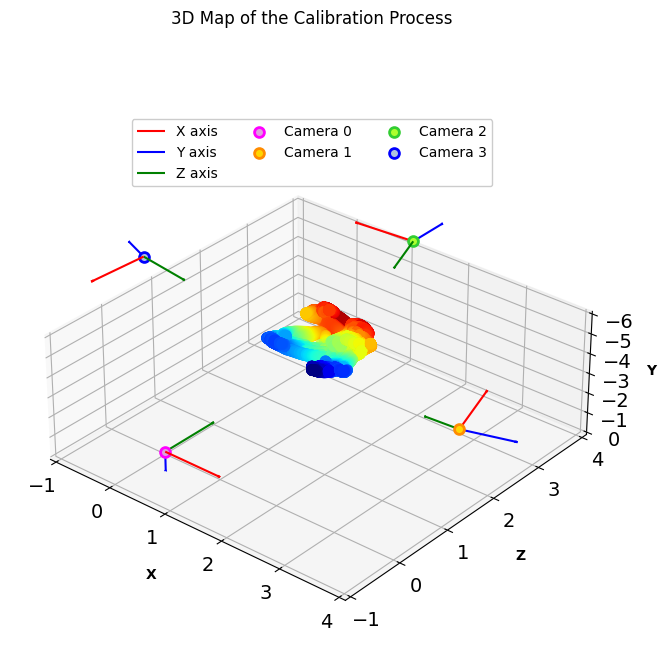

In [5]:
# Initializing arrays
allPoints3d,projMat = [],[]      
dfTriang = np.zeros((int(recTime/step),(nCameras-1)*4*3+1))
dfTriang[:,-1] = np.arange(0,recTime,step)      

# Getting coordinates from each camera and 3D points in relation to the 0th camera
for cam in range(nCameras):
    # Initialize initial values of the projection matrices
    P_new = np.vstack((np.hstack((np.identity(3),np.zeros((3,1)))),np.hstack((np.zeros((3)),1))))

    # Iterate over the previous cameras to find the relation to the 0th camera
    # E.g. 3 -> 2 -> 1 -> 0
    for i in np.flip(range(cam+1)):
        t,R,lamb = np.array(translation[i][0]).reshape(-1,3),np.array(rotation[i]),scale[i]
        t_new = np.matmul(-t, R).reshape(-1,3)*lamb/100
        P = np.vstack((np.hstack((R.T,t_new.T)),np.hstack((np.zeros((3)),1))))
        P_new = np.matmul(P,P_new)

    # Save new projection matrix
    projMat.append(P_new)

    # Save triangulated 3D points in relation to the 0th camera
    if cam < nCameras-1:
        points3d = np.hstack((points3D_perPair[cam]*scale[cam+1][0]/100,np.ones((points3D_perPair[cam].shape[0],1)))).T
        points3d = np.matmul(P_new,points3d)
        dfTriang[np.array(ts_perPair[cam]*(1/step)).astype(int),cam*12:(cam+1)*12] = points3d.T.reshape(-1,12)
        if not len(allPoints3d): 
            allPoints3d = points3d.copy()
        else: 
            allPoints3d = np.hstack((allPoints3d,points3d.copy()))

# Prepare camera data
cameraData = {'projectionMatrices': projMat}

plotArena(title='3D Map of the Calibration Process', 
          allPoints3d=allPoints3d, 
          cameraData=cameraData)

## Calibration of ground plane

The following cell sets up the name of the CSV where the data is stored and the size of the arrays to be read. Alter to the options used with the `GPE.py` command.

In [7]:
##########################################
### YOU MAY CHANGE THE VARIABLES BELOW ###
##########################################

dfCSV = np.genfromtxt('dataSaves/27-09-23/GPE-18-00-50.csv', delimiter=',')

### Centroid ordering

As we already know the fundamental matrix between the cameras 0 and 1, we use the epipolar line approach to order the centroids. Because the wand is still, we do not need to interpolate the points. 

In [8]:
## initiate variables
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)

# read from CSV
while i!=dfCSV.shape[0]:
    # get data from the line
    line = dfCSV[i]
    idx = int(line[8])
    undCoord,timeNow,imgNumber = line[0:6].reshape(-1,2),line[6],line[7]
    # save points
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(6),timeNow))
    # update datasets variables
    i+=1
    counter[idx]+=1
    # do I have enough points? break if yes
    if np.all(counter>0): break

# order centroids
for cam in range(nCameras-1):
    # collect extrinsics from calibration between camera 0 and 1
    F = FMatrix[cam]
    R,t,lamb = rotation[cam+1],translation[cam+1].reshape(-1,3),scale[cam+1]
    # order centroids per epipolar line
    pts1,pts2 = dfOrig[cam][0:6].reshape(-1,2),dfOrig[cam+1][0:6].reshape(-1,2)
    orderSecondFrame = getOrderPerEpiline(pts1,pts2,3,np.copy(F))
    pts2 = np.copy(pts2[orderSecondFrame])
    # save dataset
    dfOrig[cam+1][0:6] = pts2.copy().ravel()
    # plot corresponding centroids 
    '''pts1,pts2 = np.int32(pts1),np.int32(pts2)
    img1,img2 = np.zeros((720,960)),np.zeros((720,960))
    lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,_ = drawlines(img1,img2,lines1,pts1,pts2)
    lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,_ = drawlines(img2,img1,lines2,pts2,pts1)
    plt.figure(figsize=(8, 6),dpi=100)
    plt.imshow(img5.astype(np.uint8)) 
    plt.axis('off') 
    plt.show()
    plt.figure(figsize=(8, 6),dpi=100)
    plt.imshow(img3.astype(np.uint8))
    plt.axis('off') 
    plt.show()''';

### Triangulation and plane estimation

We use the ordered centroids and triangulate using the calibrated extrinsics. We may then find the plane that passes trought the three triangulated points and the rigid body transformation to make it equal to the ground XZ plane. 

Firstly, we translate the plane `d/b` units to match the Y axis origin. After, we rotate it to meet as close as possible the plane `y = 0`. Finally we displace all cameras so the 0th camera occupies `[0,h,0]`, for `h` the height of the camera.

[RESULTS] Maximum Y: 3.1891136429961146e-16
[RESULTS] Minimum Y: 1.9122812431975954e-16


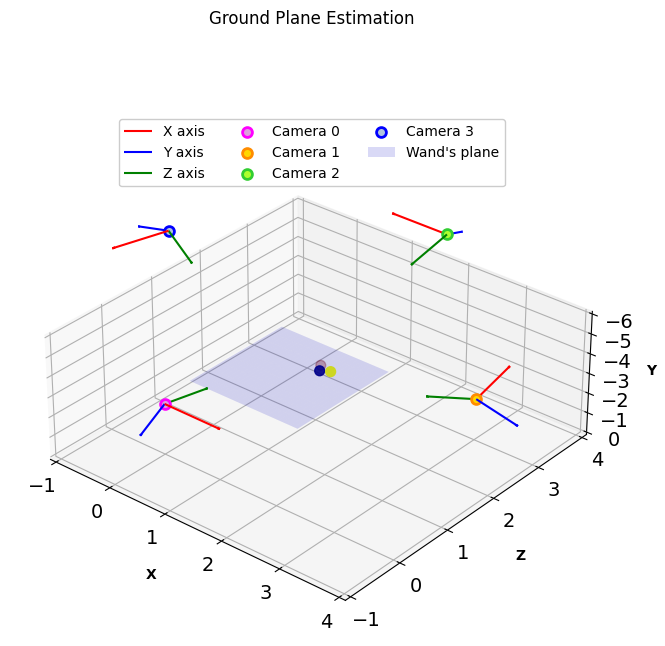

In [9]:
# Triangulate ordered centroids from the first pair
pts1,pts2 = np.copy(dfOrig[0][0:6].reshape(-1,2)),np.copy(dfOrig[1][0:6].reshape(-1,2))
R,t,lamb = rotation[1],translation[1].reshape(-1,3),scale[1]
P1,P2 = np.hstack((cameraMat[0], [[0.], [0.], [0.]])),np.matmul(cameraMat[1], np.hstack((R, t.T)))
projPt1,projPt2 = projectionPoints(np.array(pts1)),projectionPoints(np.array(pts2))
points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T
if points3d[0, 2] < 0: 
    points3d = -points3d
allPoints3d = points3d*lamb/100

# Get ground plane coefficients
plane = findPlane(allPoints3d[0],allPoints3d[1],allPoints3d[2])
if np.any(plane[0:3]<0): 
    plane = findPlane(allPoints3d[0],allPoints3d[2],allPoints3d[1])
[a,b,c,d] = plane

# Get the orthonogal vector to the plane
v,k = np.array([a,b,c]),np.array([0,1,0])

# Compute the angle between the plane and the y axis
cosPhi = np.dot(v,k)/(np.linalg.norm(v)*np.linalg.norm(k))

# Compute the versors
[u1,u2,u3] = np.cross(v,k)/np.linalg.norm(np.cross(v,k))

# Get the rotation matrix and new ground plane coefficients
sinPhi = np.sqrt(1-pow(cosPhi,2))
R_plane = np.array([
        [cosPhi+u1*u1*(1-cosPhi),u1*u2*(1-cosPhi)-u3*sinPhi,u2*sinPhi+u1*u3*(1-cosPhi)],
        [u1*u2*(1-cosPhi)+u3*sinPhi,cosPhi+u2*u2*(1-cosPhi),u2*u3*(1-cosPhi)-u1*sinPhi],
        [u1*u3*(1-cosPhi)-u2*sinPhi,u2*u3*(1-cosPhi)+u1*sinPhi,cosPhi+u3*u3*(1-cosPhi)]])
[A,B,C] = np.matmul(R_plane,np.array([a,b,c]).T)

# Preparing ground data 
P_plane = np.vstack((np.hstack((R_plane,np.array([0,0,0]).reshape(3,-1))),np.hstack((np.zeros((3)),1))))
newPlane = np.array([A,B,C])

groundData = {'planeDisplacement': d/b, 
              'planeRotation': P_plane,
              'planeCoefficients': newPlane}

# Preparing camera data
o = np.matmul(projMat[0],[[0.],[0.],[0.],[1]]).ravel()
o += [0,d/b,0,0] # Displace in relation to ground
o = np.matmul(P_plane,o).ravel() # Rotate in relation to ground
h = o[2] # Let 'h' be the height of the 0th camera

cameraData = {'cameraHeight': h,
              'projectionMatrices': projMat}

# Preparing captured data 
allPoints3d = np.hstack((allPoints3d,np.ones((allPoints3d.shape[0],1))))
allPoints3d += [0,d/b,0,0]
allPoints3d = np.matmul(P_plane,allPoints3d.T).T
allPoints3d += [0,0,-h,0]
allPoints3d = allPoints3d.T

plotArena(title='Ground Plane Estimation', 
          allPoints3d=allPoints3d, 
          cameraData=cameraData, 
          groundData=groundData)

## Testing flight

The following cell sets up the name of the CSV where the data is stored and the size of the arrays to be read. Alter to the options used with the `SCR.py` command.

In [11]:
##########################################
### YOU MAY CHANGE THE VARIABLES BELOW ###
##########################################

dfCSV = np.genfromtxt('dataSaves/27-09-23/SCR-18-06-58.csv', delimiter=',')
recTime = 10     # Recording time, in seconds
step = 1/100     # Step of the interpolated DF
nMarkers = 3     # Expected number of markers
isDrone = False  # Should I realign the point cloud to match the drones X and Y axis

# flags
saveDF = False                 # Save dataframe 
whichCamera = ''               # Save which camera
saveFolder = '/home/debora/Desktop/MoCapRasp/server/data/' # Folder where to save DF

### Reading coordinates, ordering and triangulating markers

Now we do ordering and triangulation inside the reading loop. The epiline approach for ordering tests 16 possibilities at each loop, so we keep track of the camera pairs that needs ordering of the centroids. When at least one image is ordered, the blobs in following ones are tracked by proximity. The reference is reset if more than 10 images are invalid (per time missmatch or occlusion)

Nevertheless, we can only relate the two cameras when all four markers are visible at the same time. We do as following:

- Wait for the cameras to have at least 3 images in storage for the actual valid interval.
- Check which cameras still need to be related to the one that sent the last package.
- If yes, check if valid time interval of this other camera has intesection with that camera that sent the last package.
- If yes, we order the blobs at the first intersection timestamp per epipolar line.
- Then we flip the blobs according to this order on the second camera (sorted by index) in the non interpolated database since the beggining fo the actual valid time interval.
- We notify that any camera index comming after this second camera index also needs reordering when the next package is received.

Then, for triangulation, we follow as:

- Wait for the cameras to have at least 10 images in storage for the actual valid interval to start triangulating
- Interpolate the blobs that have not been already interpolated.
- Check if any of the interpolated images are also seen by any other camera (always neighbours).
- Triangulate markers with this camera (including projection matrix, ground plane rotation and correction matrix).


[INFO] found 992 interpolated pics
[INFO] Temporal analysis
	> Min: 7e-05 s
	> Mean: 0.00052 s
	> Max: 0.02437 s
	> Std. Dev.: 0.00064 s


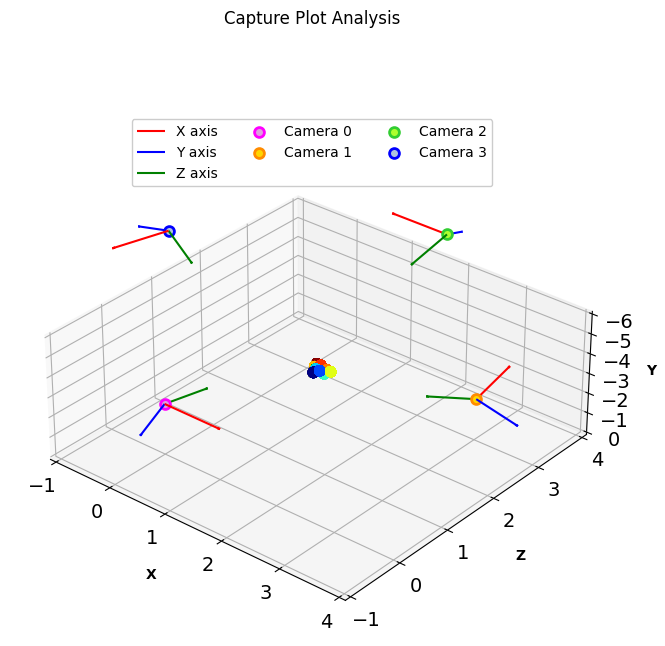

In [13]:
# Initiating empty arrays
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)
missed,invalid,swap = np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32)
lastImgNumber = np.zeros(nCameras,dtype=np.int32)
intervals,lastTnew = [],[]

# WarmUp = number of images in storage for the actual valid interval to start triangulating
# nPrevious = number of images in camera storage for the actual valid interval
dfOrig,nPrevious,warmUp = [],3,10 # Warm up > n previous 

needsOrder = createNeedsOrder(nCameras,relateLast2First=0)

allPoints3d = [] # List of all 3D points in the whole footage

verbose = False # Verbose Info

for _ in range(nCameras): # For each camera
    dfOrig.append([]) # List for each camera
    intervals.append([]) # List for each camera
    lastTnew.append([]) # List for each camera

# Each PTS will have a 2D marker coordinate for each camera + 2 additional columns
dfInterp = np.zeros((int(recTime/step),nCameras*(2*nMarkers)+2)) # Last two columns are special

dfInterp[:,-2] = np.arange(0,recTime,step) # Penultimate column is filled with the time stamps
dfInterp[:,-1] = np.zeros_like(dfInterp[:,-1],dtype=np.bool8) # Last column is filled with bool zeros (false)

# Each PTS will have...
dfTriang = np.zeros((int(recTime/step),(4*nMarkers)+1)) # 4D coordinates of each marker + PTS
dfTriang[:,-1] = np.arange(0,recTime,step) # Last column is filled with the PTSs

timeArray = []
otherCamera = findOtherCamera(whichCamera,nCameras)

# Test loop done in real time
while i != dfCSV.shape[0]: # Capture frames
    start = time.time() # Just to measure loop time
    line = dfCSV[i] # Current frame info
    
    # Get data from the line
    # Lines are: 2D Coordinates from each marker | Current time | Image number | Camera Index
    undCoord,timeNow,imgNumber, idx = line[0:(2*nMarkers)].reshape(-1,2), line[-3], line[-2], int(line[-1])

    i += 1 # Update to next frame for next iteration

    if len(otherCamera): # If there is camera available in otherCamera
        if idx in otherCamera: continue # If Camera is in otherCamera

    # Time missmatch
    if counter[idx]:
        if abs(timeNow-lastTime[idx])>1e9: 
            if verbose: print('time missmatch')
            missed[idx] += 1 # One more missed image for the camera
            invalid[idx] += 1 # One more invalid image for the camera
            continue
    
    # Check if sequence is valid
    if imgNumber > lastImgNumber[idx] + 1: invalid[idx] = imgNumber-lastImgNumber[idx]

    # Check occlusion and order markers per proximity
    if not occlusion(undCoord,5) and not np.any(undCoord<0): 
        if invalid[idx]>=10 or not counter[idx]: 
            if verbose: print('reseting at camera', idx,', counter',counter[idx],',',timeNow/1e6,'s')
            prev,needsOrder = [],activateNeedsOrder(nCameras,idx,needsOrder,relateLast2First=0)
            intervals[idx].append(counter[idx])
        else:
            if not (counter[idx]-1): prev = np.array(dfOrig[idx][0:(2*nMarkers)]).reshape(-1,2)
            else: prev = np.array(dfOrig[idx][-1,0:(2*nMarkers)]).reshape(-1,2)
            newOrder = getTheClosest(undCoord.reshape(-1,2),prev.reshape(-1,2))
            undCoord = np.copy(undCoord[newOrder])
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx] += 1 # One more missed image for the camera
        invalid[idx] += 1 # One more invalid image for the camera
        continue

    # Update loop variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = timeNow,imgNumber,0    
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(2*nMarkers),timeNow))
    else: dfOrig[idx] = np.vstack((dfOrig[idx],np.hstack((undCoord.reshape(2*nMarkers),timeNow))))
    counter[idx] += 1

    # Interpolate
    if needsOrder[str(idx)].size:
        # Get if there are enough points at the valid interval
        for otherIdx in needsOrder[str(idx)]:
            if not len(intervals[otherIdx]): continue
            myCounter,myIntervals = np.array([counter[idx],counter[otherIdx]]),np.array([intervals[idx][-1],intervals[otherIdx][-1]])            
            if np.all(myCounter-myIntervals>=nPrevious):
                # See if there are intersection between arrays
                ts1,ts2 = dfOrig[idx][intervals[idx][-1]:counter[idx],(2*nMarkers)]/1e6,dfOrig[otherIdx][intervals[otherIdx][-1]:counter[otherIdx],(2*nMarkers)]/1e6
                validIdx1 = [k for k in range(0,len(ts1)) if max(ts1[0], ts2[0])-0.01<=ts1[k]<=min(ts1[-1], ts2[-1])+0.01]
                validIdx2 = [k for k in range(0,len(ts2)) if max(ts1[0], ts2[0])-0.01<=ts2[k]<=min(ts1[-1], ts2[-1])+0.01]
                
                # if there is intersection, get order
                if len(validIdx1) and len(validIdx2):
                    ts1,ts2 = np.copy(ts1[validIdx1]),np.copy(ts2[validIdx2])
                    if ts1.shape[0]<2 or ts2.shape[0]<2: continue
                    coord1,coord2 = dfOrig[idx][intervals[idx][-1]:counter[idx],0:(2*nMarkers)],dfOrig[otherIdx][intervals[otherIdx][-1]:counter[otherIdx],0:(2*nMarkers)]
                    coord1,coord2 = np.copy(coord1[validIdx1]),np.copy(coord2[validIdx2])
                   
                    # Get interpolated data
                    interp1,tNew1 = interpolate(coord1,ts1,step)
                    interp2,tNew2 = interpolate(coord2,ts2,step)
                    if not len(interp1) or not len(interp2): continue
                    
                    # Get min and max idx
                    minIdx,maxIdx = min(idx,otherIdx),max(idx,otherIdx)
                    
                    # Get common idx
                    F = FMatrix[minIdx]
                    interpolateIdx1,interpolateIdx2 = np.argmax(np.in1d(tNew1, tNew2)),np.argmax(np.in1d(tNew2, tNew1))
                  
                    # Order per epipolar line
                    if idx < otherIdx: orderSecondFrame,ret = getOrderPerEpiline(interp1[-1],interp2[-1],nMarkers,F,0,1)
                    else: orderSecondFrame,ret = getOrderPerEpiline(interp2[-1],interp1[-1],nMarkers,F,0,1)
                    if not ret: 
                        if verbose: print(minIdx,maxIdx,'could not rearange at',tNew2[-1]*step,'s')
                        continue
                    
                    # Get interval to rearrange
                    if verbose: print(minIdx,maxIdx,'rearanging interval',[intervals[maxIdx][-1],counter[maxIdx]], 'to', orderSecondFrame, 'at',tNew2[-1]*step,'s')
                   
                    # Flip blobs
                    for k in range(intervals[maxIdx][-1],counter[maxIdx]):
                       dfOrig[maxIdx][k,0:(2*nMarkers)] = np.copy(dfOrig[maxIdx][k,0:(2*nMarkers)].reshape(-1,2)[orderSecondFrame].reshape(-(2*nMarkers)))
                   
                    # Change ordering boolean
                    needsOrder=popNeedsOrder(idx,otherIdx,needsOrder)
                    for k in range(maxIdx+1,nCameras):
                        needsOrder=activateNeedsOrder(nCameras,k,needsOrder,relateLast2First=0) 

    if (counter[idx]-intervals[idx][-1]) >= warmUp: 
        # Get data to interpolate
        coord,ts = dfOrig[idx][(counter[idx]-warmUp):counter[idx],0:(2*nMarkers)],dfOrig[idx][(counter[idx]-warmUp):counter[idx],(2*nMarkers)]/1e6
        if not len(ts): continue
        lowBound,highBound = math.ceil(ts[0]/step),math.floor(ts[-1]/step)

        # Avoid repeating intepolation
        if lastTnew[idx]:
            if lowBound<lastTnew[idx]: lowBound = lastTnew[idx]+1

        # Interpolate
        tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
        ff = CubicSpline(ts,coord,axis=0)

        # Save data
        dfInterp[tNew,int(idx*(2*nMarkers)):int(idx*(2*nMarkers)+(2*nMarkers))] = ff(tNew*step)
        lastTnew[idx] = tNew[-1]

        # Compare if there is another camera available
        for k in tNew:
            if dfInterp[k,-1]: continue
            otherIdx = getOtherValidIdx(dfInterp[k,:],nMarkers,idx)      
            if not len(otherIdx) or otherIdx in needsOrder[str(idx)]: continue      

            # Get index from the other camera
            dfInterp[k,-1],otherIdx = True,otherIdx[0]

            # Comparing the indexes to set the projection matrices
            minIdx,maxIdx = min(idx,otherIdx),max(idx,otherIdx)

            # Getting the data
            pts1,pts2 = dfInterp[k,minIdx*(2*nMarkers):(minIdx+1)*(2*nMarkers)].reshape(-1,2),dfInterp[k,maxIdx*(2*nMarkers):(maxIdx+1)*(2*nMarkers)].reshape(-1,2)
            R,t,lamb = rotation[maxIdx],translation[maxIdx].reshape(-1,3),scale[maxIdx]
            P1,P2 = np.hstack((cameraMat[minIdx], [[0.], [0.], [0.]])),np.matmul(cameraMat[maxIdx], np.hstack((R, t.T)))
            projPt1,projPt2 = projectionPoints(np.array(pts1)),projectionPoints(np.array(pts2))

            # Triangulate
            points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
            points3d = (points4d[:3, :]/points4d[3, :]).T
            if points3d[0, 2] < 0: points3d = -points3d  

            # Project in scale regarding the minimum index camera
            points3d = np.hstack((points3d*lamb/100,np.ones((points3d.shape[0],1)))).T
            points3d = np.matmul(projMat[minIdx],points3d).T

            # Rotate to ground plane
            points3d += [0,d/b,0,0]
            points3d = np.matmul(P_plane,points3d.T).T
            points3d += [0,0,-h,0]
            
            # Save to array
            dfTriang[k,0:(4*nMarkers)] = np.copy(points3d.ravel()) 
            if not len(allPoints3d): allPoints3d = np.copy(points3d)
            else: allPoints3d = np.vstack((allPoints3d,np.copy(points3d))) 

    timeArray.append(time.time()-start)

# Just comprising dataset if wanted to plot
emptyLines = np.unique([i for i in range(0,dfInterp.shape[0]) if not dfInterp[i][-1]])
dfInterp = np.delete(dfInterp,emptyLines,axis=0)
dfTriang = np.delete(dfTriang,emptyLines,axis=0)
print('[INFO] found ' +str(dfTriang.shape[0])+ ' interpolated pics')
# Time plot for further temporal analysis
print('[INFO] Temporal analysis')
print('\t> Min:',round(np.min(timeArray),5),'s')
print('\t> Mean:',round(np.mean(timeArray),5),'s')
print('\t> Max:',round(np.max(timeArray),5),'s')
print('\t> Std. Dev.:',round(np.std(timeArray),5),'s')
allPoints3d = np.array(allPoints3d).T

# Save dataset
if saveDF:
    name = 'dfTriang_'
    if len(whichCamera): name += whichCamera
    else: name += 'Mix'
    np.savetxt(saveFolder+name+'.csv',dfTriang,delimiter=',')

# Prepare data for plotting
groundData = {'planeDisplacement': d/b, 
              'planeRotation': P_plane}

cameraData = {'cameraHeight': h,
              'projectionMatrices': projMat}

# Plotting
plotArena(title='Capture Plot Analysis', 
          allPoints3d=allPoints3d, 
          cameraData=cameraData, 
          groundData=groundData)

# Image debug for interpolated dataset
'''for idx in range(nCameras):
    os.system('del -rf pics\cam'+str(idx+1)+'\*jpg')
    for j in range(0,dfInterp.shape[0]):
        pts,name,img,k = dfInterp[j,int(idx*8):int(idx*8+8)].reshape(-1,2),int(dfInterp[j,-2]/step),np.ones((720,960,3))*255,0
        for k in range(0,4):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)''';